In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!mkdir -p mmsegmentation/data/voc2009/images/{training,validation}

In [3]:
!pip3 install openmim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 3.2 MB/s 
     |████████████████████████████████| 235 kB 9.2 MB/s 
     |████████████████████████████████| 51 kB 9.0 MB/s 


In [4]:
!mim install mmcv-full

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 40.6 MB 11.2 MB/s 
     |████████████████████████████████| 190 kB 5.0 MB/s 


In [5]:
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 10517, done.
remote: Counting objects: 100% (392/392), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 10517 (delta 169), reused 313 (delta 141), pack-reused 10125
Receiving objects: 100% (10517/10517), 14.19 MiB | 22.28 MiB/s, done.
Resolving deltas: 100% (7609/7609), done.
/content/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation
     |████████████████████████████████| 578 kB 4.6 MB/s 
  Running setup.py develop for mmsegmentation


In [6]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.1+cu113 True
0.27.0


In [7]:
!mkdir checkpoints
#bir faydasını farketmedim
!wget https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_512x512_160k_ade20k/segformer_mit-b5_512x512_160k_ade20k_20210726_145235-94cedf59.pth -P checkpoints

--2022-08-24 22:57:50--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_512x512_160k_ade20k/segformer_mit-b5_512x512_160k_ade20k_20210726_145235-94cedf59.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.89.140.71
Connecting to download.openmmlab.com (download.openmmlab.com)|47.89.140.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328404259 (313M) [application/octet-stream]
Saving to: ‘checkpoints/segformer_mit-b5_512x512_160k_ade20k_20210726_145235-94cedf59.pth’

segformer_mit-b5_51 100%[===================>] 313.19M  8.66MB/s    in 37s     

2022-08-24 22:58:27 (8.57 MB/s) - ‘checkpoints/segformer_mit-b5_512x512_160k_ade20k_20210726_145235-94cedf59.pth’ saved [328404259/328404259]



In [ ]:
#!mkdir /content/mmsegmentation/data

In [8]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [17]:
#klasörlerdeki dosya sayıları
!ls /content/drive/MyDrive/data/perde/fon-stor-tul-data/jpgimage/train_images | wc -l
!ls /content/drive/MyDrive/data/perde/fon-stor-tul-data/jpgimage/train_images | wc -l

558
558


In [12]:
#JPEGImages klasöründeki fazla resimleri siliyoruz
import os
import os.path as osp
data_root = '/content/drive/MyDrive/data/perde/fon-stor-tul-data'
img_dir='jpgimage/train_images'
ann_dir='pngimage/train_png'

'''
#annotion'ı olmayan resimleri siliyoruz
resimler=os.listdir(osp.join(data_root, img_dir))
segmentler = os.listdir(osp.join(data_root, ann_dir))

for r in resimler:
  if (r[:-3]+'png' not in segmentler):
    os.remove(osp.join(data_root, img_dir,r))
'''



"\n#annotion'ı olmayan resimleri siliyoruz\nresimler=os.listdir(osp.join(data_root, img_dir))\nsegmentler = os.listdir(osp.join(data_root, ann_dir))\n\nfor r in resimler:\n  if (r[:-3]+'png' not in segmentler):\n    os.remove(osp.join(data_root, img_dir,r))\n"

In [13]:

classes = ('bg','tul' , 'stor' , 'guneslik')
palette=[[0,0,0],[128,0,0],[0,128,0],[128,128,0]]

print(len(classes))
print(len(palette))
#palete arka plan ve beyazımsı diğerlerini de ekliyoruz


4
4


In [ ]:
# split train/val set randomly
'''
import mmcv
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # train klasöründekileri ekliyoruz

  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])
  '''

In [15]:
# 1 defalık
# !cp /content/drive/MyDrive/data/perde/fon-stor-tul-data/pngimage/test_png/* /content/drive/MyDrive/data/perde/fon-stor-tul-data/pngimage/train_png

In [16]:
# 1 defalık
# !cp /content/drive/MyDrive/data/perde/fon-stor-tul-data/jpgimage/test_images/* /content/drive/MyDrive/data/perde/fon-stor-tul-data/jpgimage/train_images

In [18]:
# 1 kere yapman yeter
# split train/val set mevcut klasor ayrimina gore
# test_png ve test_jpg klasorlerini train_png ve train_jpg klasorlerine kopyaladık
'''
import mmcv

split_dir = 'splits'
val_dir='pngimage/test_png'
train_seti=os.listdir(osp.join(data_root, ann_dir))
val_seti=os.listdir(osp.join(data_root, val_dir))

mmcv.mkdir_or_exist(osp.join(data_root, split_dir))

filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]

with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # train klasöründekileri ekliyoruz
  f.writelines(line + '\n' for line in filename_list)


filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, val_dir), suffix='.png')]

with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list)

'''

In [19]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class FonStorDataSet(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

In [32]:
import torch
torch.cuda.empty_cache()

In [33]:
from mmcv import Config

#config_file='/content/mmsegmentation/configs/segformer/test_segformer_mit-b5_512x512_voc2009.py'
config_file='/content/mmsegmentation/configs/segformer/segformer_mit-b5_512x512_160k_ade20k.py'
checkpoint_file = 'checkpoints/segformer_mit-b5_512x512_160k_ade20k_20210726_145235-94cedf59.pth'

cfg = Config.fromfile(config_file)


In [34]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
#cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.dataset_type = 'FonStorDataSet'
cfg.data_root = data_root
cfg.model.decode_head.num_classes = len(classes) #sınıf sayısı (arkaplan dahil)
#cfg.model.auxiliary_head.num_classes = len(classes)


cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8


cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256) #eğitim resimlerinin yarısı olabilir
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'), #img_scale eğitim seti ortalamsı kadar olmalı
    dict(type='Resize', img_scale=(512, 512), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]



cfg.load_from = checkpoint_file #bir faydasını farkedemedim
cfg.work_dir = './work_dirs/tutorial'
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

cfg.runner.max_iters = 2000 #toplam iterasyon
cfg.log_config.interval = 100 #kaç iterasyonda bir sonuçları göstersin
cfg.evaluation.interval = 2000 #kaç iterasyonda bir genel (IoU...) sonuçları göstersin
cfg.checkpoint_config.interval = 2000 #kaç iterasyonda bir pth dosyasını kaydetsin


In [35]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=
    'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segformer/mit_b5_20220624-658746d9.pth',
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=4,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_we

In [36]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import mmcv
import os.path as osp


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-08-24 23:12:27,658 - mmseg - INFO - Loaded 558 images
2022-08-24 23:12:29,557 - mmseg - INFO - Loaded 100 images
2022-08-24 23:12:29,562 - mmseg - INFO - load checkpoint from local path: checkpoints/segformer_mit-b5_512x512_160k_ade20k_20210726_145235-94cedf59.pth
2022-08-24 23:12:29,985 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([150, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([4, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([150]) from checkpoint, the shape in current model is torch.Size([4]).
2022-08-24 23:12:29,996 - mmseg - INFO - Start running, host: root@245f1a4ac926, work_dir: /content/mmsegmentation/work_dirs/tutorial
2022-08-24 23:12:29,998 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 6.2 task/s, elapsed: 16s, ETA:     0s

2022-08-24 23:36:46,431 - mmseg - INFO - per class results:
2022-08-24 23:36:46,435 - mmseg - INFO - 
+----------+-------+-------+
|  Class   |  IoU  |  Acc  |
+----------+-------+-------+
|    bg    | 94.34 | 95.84 |
|   tul    | 89.51 | 96.99 |
|   stor   | 89.92 | 97.38 |
| guneslik | 88.78 | 94.78 |
+----------+-------+-------+
2022-08-24 23:36:46,437 - mmseg - INFO - Summary:
2022-08-24 23:36:46,440 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.92 | 90.64 | 96.25 |
+-------+-------+-------+
2022-08-24 23:36:46,444 - mmseg - INFO - Iter(val) [100]	aAcc: 0.9592, mIoU: 0.9064, mAcc: 0.9625, IoU.bg: 0.9434, IoU.tul: 0.8951, IoU.stor: 0.8992, IoU.guneslik: 0.8878, Acc.bg: 0.9584, Acc.tul: 0.9699, Acc.stor: 0.9738, Acc.guneslik: 0.9478


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


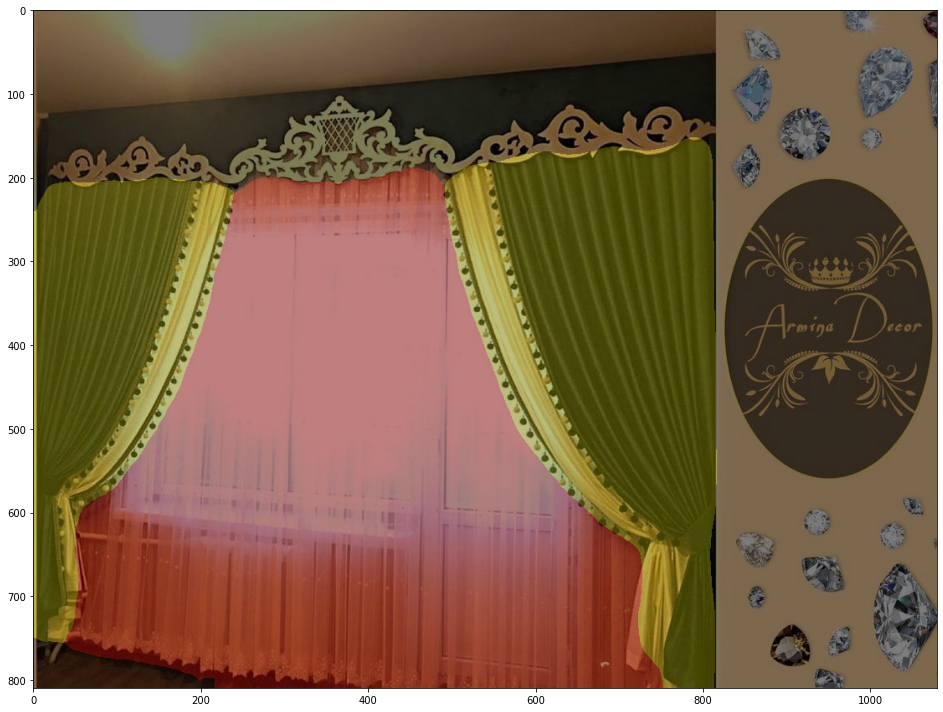

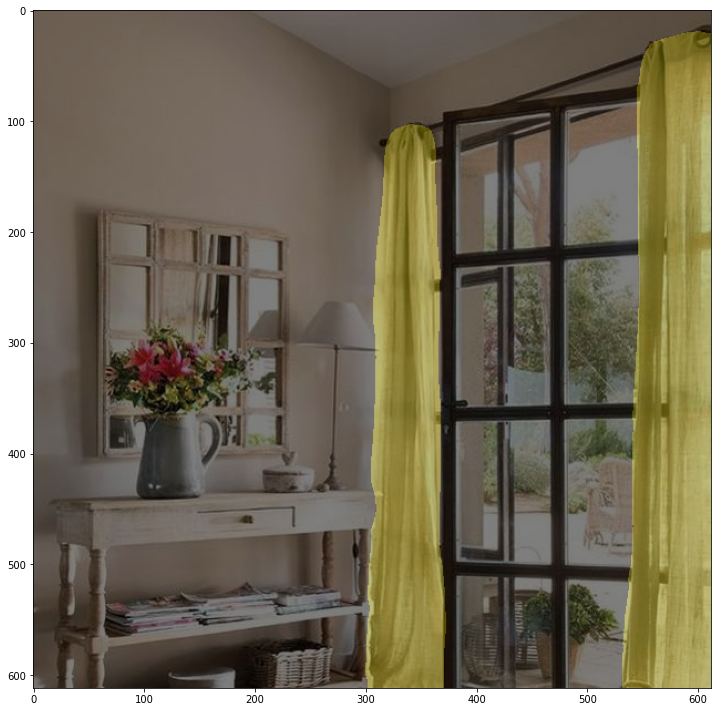

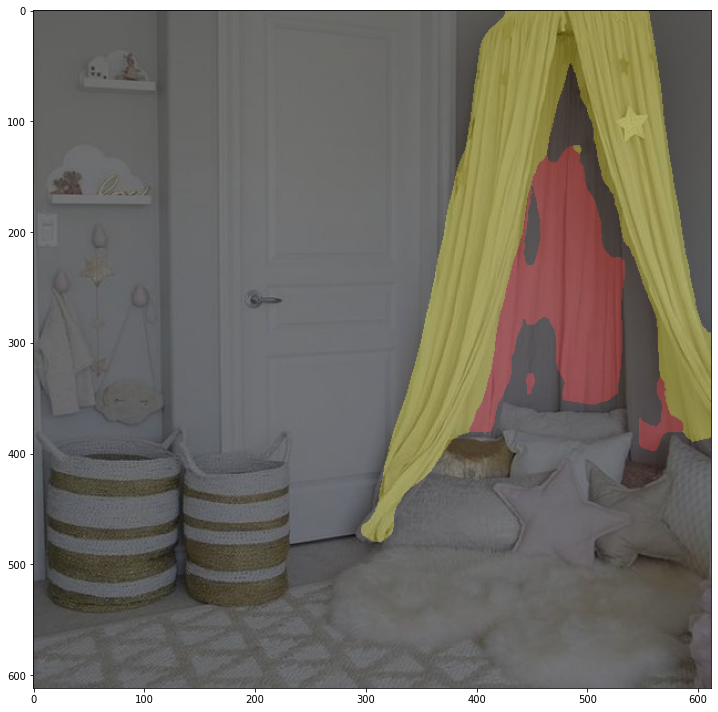

In [37]:
import matplotlib.pyplot as plt
from mmseg.core.evaluation import get_palette
model.cfg = cfg
dirrr = '/content/drive/MyDrive/data/perde/fon-stor-tul-data/jpgimage/test_images/'
resimler=['2020-01-04_24.jpg' , '2020-04-06_B-ocLjrHFXU_2281197148502236546.jpg' , 
          '2020-06-17_CBh1aivnC6M_2333380999949068141.jpg']
for img in resimler:
  result = inference_segmentor(model, dirrr+img)
  show_result_pyplot(model, dirrr+img, result,palette)





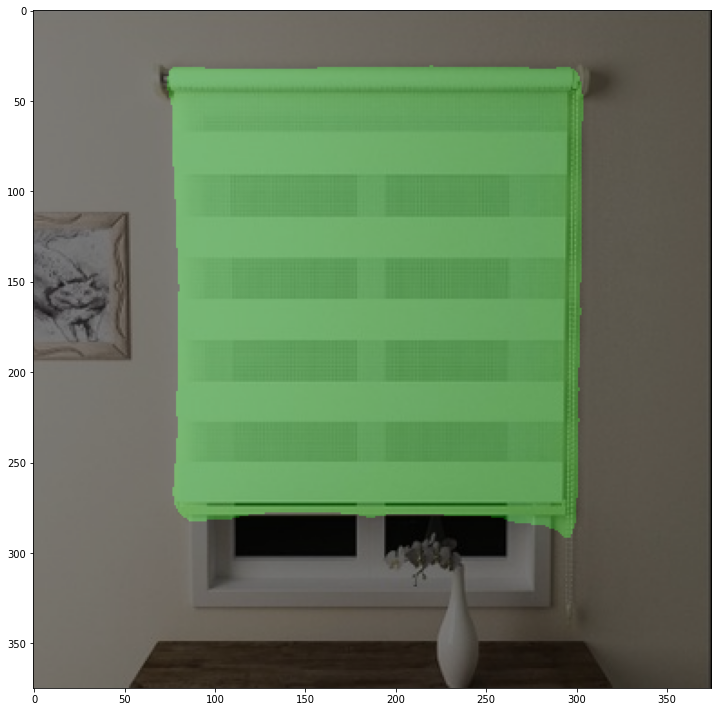

In [44]:
img='/content/10147478274098.jpg'
result = inference_segmentor(model, img)
show_result_pyplot(model, img, result,palette)

In [45]:
#pth dosyasını drive'a kopyalıyoruz
#!cp -v /content/mmsegmentation/work_dirs/tutorial/iter_2000.pth /content/drive/MyDrive

'/content/mmsegmentation/work_dirs/tutorial/iter_2000.pth' -> '/content/drive/MyDrive/iter_2000.pth'
